# Poisson modeling using ARIMA models

In [2]:
import math
import numpy
import matplotlib.pyplot as plt
from src.poisson import Poisson
from src.arima import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
import pylab
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Example of our Poisson process

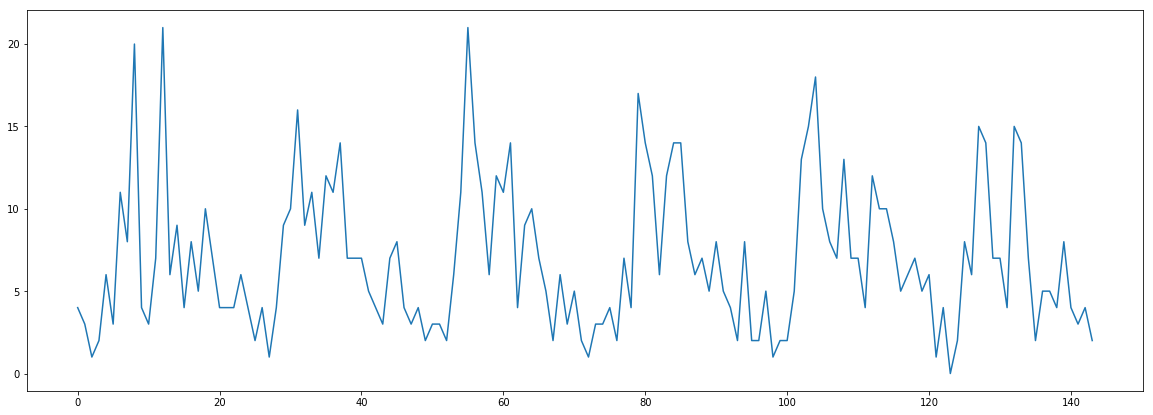

In [4]:
p = Poisson()
example, _ = p.generate(6)

plt.figure(figsize=(20,7))
plt.plot(example)

### Apply the ARIMA model to a new data set that is more varied

In [5]:
a1,_ = p.generate(14)
a2,_ = p.generate(3,2)
a3,_ = p.generate(8)
a4,_ = p.generate(2,2)
actual = numpy.concatenate((a1,a2,a3,a4))

arima = ARIMA()
pred = arima.predict(actual)

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Plot the prediction

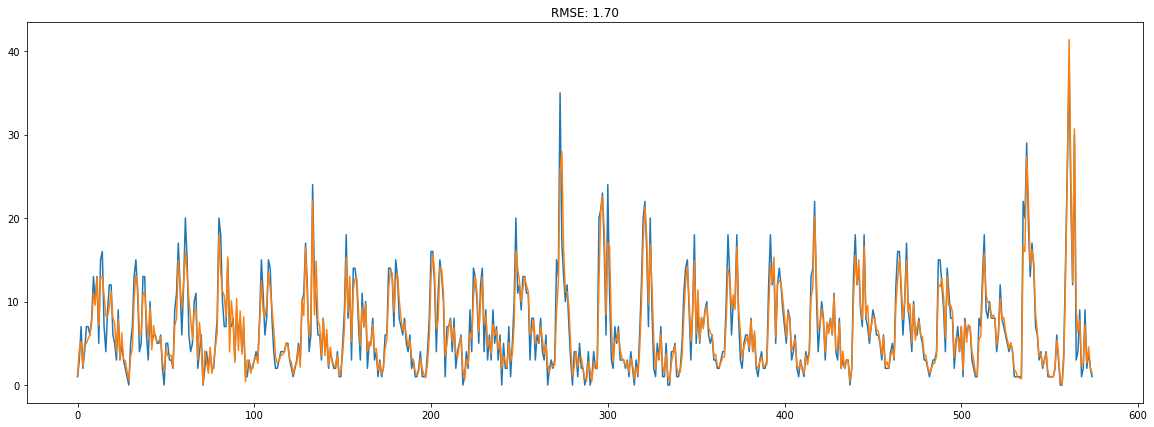

In [6]:
actual = actual[71:-2]
error = math.sqrt(mean_squared_error(pred, actual))

plt.figure(figsize=(20,7))
plt.title('RMSE: {:.2f}'.format(error))
plt.plot(actual)
plt.plot(pred)

### Evaluate the residual

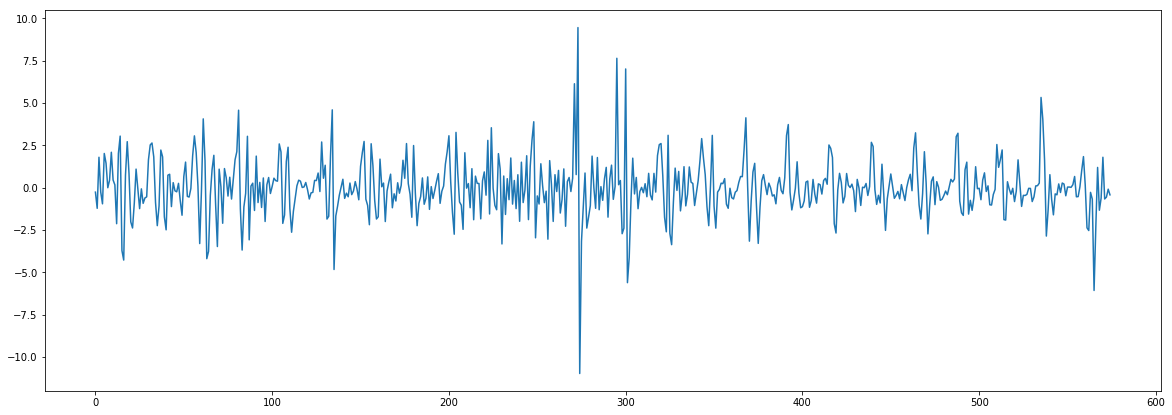

In [7]:
residual = []
for i in range(len(actual)):
    val = actual[i] - pred[i][0]
    residual.append(val)

plt.figure(figsize=(20,7))
plt.plot(residual)

That visually looks very far from normal.

### Draw the qq-plot of this data

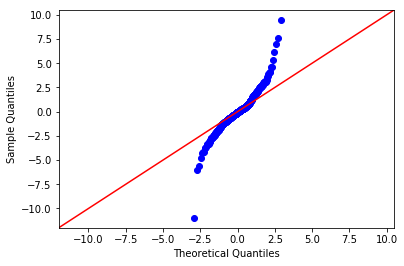

In [8]:
sm.qqplot(numpy.array(residual), line='45')
pylab.show()

Pretty bad!

### Use the normed Poisson and look at the residual

In [9]:
_, a1 = p.generate(14)
_, a2 = p.generate(3,2)
_, a3 = p.generate(8)
_, a4 = p.generate(2,2)
actual = numpy.concatenate((a1,a2,a3,a4))

arima = ARIMA()
pred = arima.predict(actual)

actual = actual[71:-2]
error = math.sqrt(mean_squared_error(pred, actual))

residual = []
for i in range(len(actual)):
    val = actual[i] - pred[i][0]
    residual.append(val)

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Plot the residual

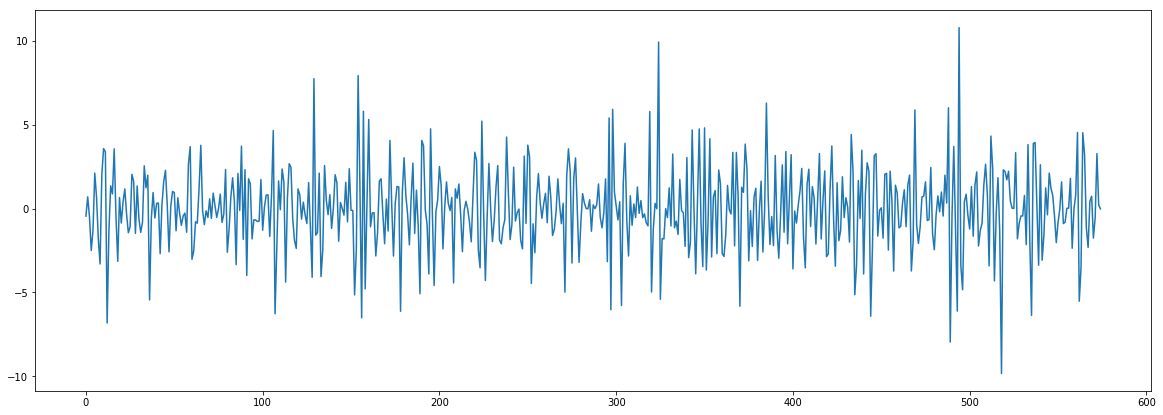

In [10]:
plt.figure(figsize=(20,7))
plt.plot(residual)

Looks a little better.

### Draw the qq-plot of the normed residual

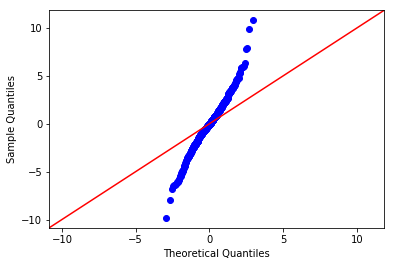

In [11]:
sm.qqplot(numpy.array(residual), line='45')
pylab.show()

But it is not!

### Let's try a wide swatch of models including seasonality, scored by AIC

In [21]:
min_period = 24
max_period = 25
max_order = 3

p = d = q = range(0, max_order)
orders = list(itertools.product(p,d,q))

results = {}
for period in range(min_period, max_period):
    for order in orders:
        for season in [(x[0], x[1], x[2], period) for x in orders]:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    actual,
                    order                 = order,
                    seasonal_order        = season,
                    enforce_stationarity  = False,
                    enforce_invertibility = False
                )
                res = mod.fit()
                results[res.aic] = 'ARIMA {} x {}'.format(order, season)
            except:
                continue

s = sorted(results)
print(results[s[-1]])

{24: 'ARIMA (2, 2, 2) x (2, 2, 2, 24)'}
ARIMA (2, 2, 2) x (2, 2, 2, 24)


### General results

The data we have here does not admit a particularly good solution with ARIMA methods.  Assuming the integral term as a means of addressing seasonality makes a big impact.  However, there are no choices of coefficient that result in a residual that is normal.  The ARIMA model does have a fairly faithful tracking of the fluctuating data because it is coupled to the data.  It tends to be better the more of the history of the function the coefficients are computed from.  For some problems this may be an adequate solution, but it should be well known that the approach leaves a lot to be desired.  Even norming the Poisson data by the mean, while changing the visual character of the residual, does not significantly alter the qq-plot.